Najlepsze parametry MLP: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Najlepsza CV Accuracy MLP: 0.5362655137396549
Validation Accuracy (MLP): 0.5338345864661654
Confusion Matrix:
[[173  16 140]
 [ 67  10 137]
 [ 58  16 314]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55       329
           1       0.24      0.05      0.08       214
           2       0.53      0.81      0.64       388

    accuracy                           0.53       931
   macro avg       0.45      0.46      0.42       931
weighted avg       0.48      0.53      0.48       931



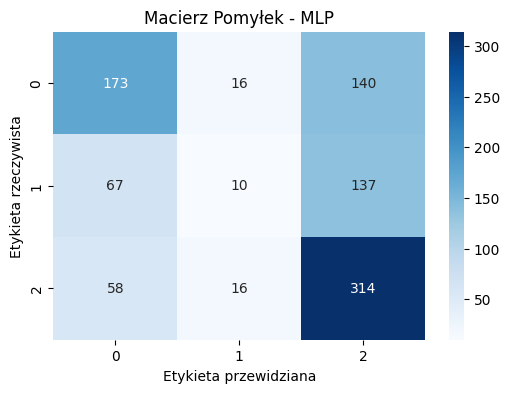

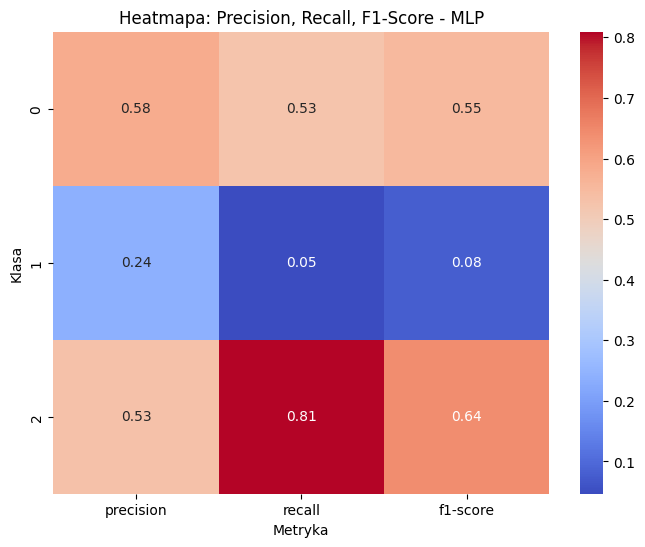

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Wczytanie danych
train = pd.read_csv('Train.csv', parse_dates=['Date'])
val = pd.read_csv('Validation.csv', parse_dates=['Date'])

# 2. Przygotowanie cech i etykiety
# Używamy tylko danych przedmeczowych:
features = [
    'B365H', 'B365D', 'B365A', 
    'BWH', 'BWD', 'BWA',
    'HomeTeam_Form', 'AwayTeam_Form',
    'H2H_net',
    'Home_ELO', 'Away_ELO'
]

X_train = train[features]
y_train = train['FTR_encoded']

X_val = val[features]
y_val = val['FTR_encoded']

# 3. Preprocessing – skalowanie cech (bardzo ważne przy MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 4. Optymalizacja hiperparametrów MLP przy użyciu GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=1000, random_state=42)
grid = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Najlepsze parametry MLP:", grid.best_params_)
print("Najlepsza CV Accuracy MLP:", grid.best_score_)

# Wybieramy najlepszy model
best_mlp = grid.best_estimator_

# 5. Predykcja i ocena modelu na zbiorze walidacyjnym
y_pred = best_mlp.predict(X_val_scaled)
acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy (MLP):", acc)

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(y_val, y_pred))

# 6. Wizualizacje
# 6.1. Heatmapa macierzy pomyłek
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Macierz Pomyłek - MLP")
plt.ylabel("Etykieta rzeczywista")
plt.xlabel("Etykieta przewidziana")
plt.show()

# 6.2. Heatmapa precision, recall i f1-score
report_dict = classification_report(y_val, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Zakładamy, że klasy są oznaczone jako '0', '1', '2'
df_metrics = df_report.loc[['0', '1', '2'], ['precision', 'recall', 'f1-score']]

plt.figure(figsize=(8, 6))
sns.heatmap(df_metrics, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmapa: Precision, Recall, F1-Score - MLP")
plt.ylabel("Klasa")
plt.xlabel("Metryka")
plt.show()
